Define Hyperparameters and Paths (Then You Can Just Run All of the Cells)

In [ ]:
WELLS = ["CCS1", "VW1", "VW2"]          #wells considered in model
MODEL_HYPERPARAMETERS = {
    "hidden_layer_sizes": (54, 18, 9),  #number of hidden layers
    "activation": "relu",               #activation function
    "solver": "adam",                   #optimizer
    "random_state": 42                  #for randoms state reciprocity
  }
K_FOLDS = 10                            #number of cross-fold learners
FORMATIONS = [                          #formations considered in model (comment out ones you want to ignore)
    "Eau Claire",
    "Mt. Simon E",
    "Mt. Simon D",
    "Mt. Simon C",
    "Mt. Simon B",
    "Mt. Simon A",
    "Argenta",
    "Precambrian"
    ]


DATALOGS_PATH = "REU Project/Data/Raw CSV Files/raw_"
LABELS_PATH = "REU Project/Data/labels/label_"
MODEL_DUMP_PATH = "REU Project/Models/MLP/"

Imports

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, mean_squared_error, \
mean_absolute_error, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import cross_val_score, KFold, \
cross_validate, StratifiedKFold
from random import randint, uniform
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight

import matplotlib.pyplot as plt

import seaborn
import joblib

Get Data and Labels

In [ ]:
datalogs = {}
labels = {}
datasets = {}
num_features = 0
for well in WELLS:
  datalogs_df = pd.read_csv(DATALOGS_PATH + well + ".csv")
  labels_df = pd.read_csv(LABELS_PATH + well + ".csv")

  #filter rock formations considered
  datalogs_df = datalogs_df[datalogs_df["FORM"].isin(FORMATIONS)]

  datalogs[well] = datalogs_df
  labels[well] = labels_df
  num_features = len(datalogs_df.columns) - 2 #exclude DEPT and FORM

  dataset = pd.merge(datalogs_df, labels_df, on='DEPT') #merge data and labels
  datasets[well] = dataset

  print(f"{well} : Shape of inputs= {datalogs_df.shape}")
  print(f"{well} : Shape of labels= {labels_df.shape}")
  print(f"{well} : Shape of merged= {dataset.shape}")

print(f"Num features: {num_features}")

CCS1 : Shape of inputs= (4217, 42)
CCS1 : Shape of labels= (4217, 2)
VW1 : Shape of inputs= (3905, 42)
VW1 : Shape of labels= (3905, 2)
VW2 : Shape of inputs= (3660, 42)
VW2 : Shape of labels= (3660, 2)


Optional Data Preprocessing Tools (Comment out function calls in final cell if you don't want to use)

In [ ]:
def normalize(X_train, X_test):
  """
  Fit normalization to training data and apply to test data. Choose standard
  standard or MinMax Scaler.
  """
  scaler = StandardScaler()
  #scaler = MinMaxScaler(feature_range=(0, 1))
  X_train = scaler.fit_transform(X_train)
  X_test = scaler.transform(X_test)
  return X_train, X_test

In [ ]:
def balance_dataset(dataset):
  """
  Undersample negative class to address bias in database. Adjust rat variable
  to change ratio of negative class to positive class data points.
  """
  df_0 = dataset[dataset['HAS_FRAC'] == 0]
  df_1 = dataset[dataset['HAS_FRAC'] == 1]

  # Randomly sample majority class so that it has rat times more data points
  # than minority class
  rat = 2
  min_samples = min(len(df_0), len(df_1))
  df_0_sampled = df_0.sample(n=min_samples * rat, replace=False)
  df_1_sampled = df_1.sample(n=min_samples, replace=False)

  # Concatenate the sampled DataFrames and shuffle
  balanced_df = pd.concat([df_0_sampled, df_1_sampled])
  balanced_df = balanced_df.sample(frac=1).reset_index(drop=True)
  return balanced_df

In [ ]:
def apply_PCA(X_train, X_test):
  """
  Returns components that explain n% of the data's variance. Adjust n variable
  to change what percentage of variance should be included. There is a more
  detailed analysis in the PCA analysis notebook.
  """
  print(f"Before PCA Xtrain, Xtest shapes: {X_train.shape}, {X_test.shape}")
  n = 0.8
  pca = PCA()
  train_pca_data = pca.fit_transform(X_train)
  test_pca_data = pca.transform(X_test)

  variance_explained = pca.explained_variance_ / np.sum(pca.explained_variance_)
  cumulative_variance_explained = np.cumsum(variance_explained)
  n_components = np.argmax(cumulative_variance_explained >= n) + 1

  new_X_train = train_pca_data[:, :n_components]
  new_X_test = test_pca_data[:, :n_components]
  print(f"After PCA Xtrain, Xtest shapes:\
   {new_X_train.shape}, {new_X_test.shape}")
  return new_X_train, new_X_test

Result Evaluation Tools

In [ ]:
def print_metrics(accuracy, precision, recall, f1):
  """
  Print accuracy, precision, recall, and f1 scores.
  """
  print(f"Average accuracy is {(accuracy * 100).round(2)}%")
  print(f"Average precision is {(precision * 100).round(2)}%")
  print(f"Average recall is {(recall * 100).round(2)}%")
  print(f"Average f1 is {(f1 * 100).round(2)}%")

In [ ]:
def plot_depths_with_labels(curr_well, depths, y_preds, test_labels):
  """
  Plots the depths that are predicted to contain fractures alongside the
  actual depths that contain fractures.
  """
  plt.figure(figsize=(8, 6))
  plt.ylabel("Depth [ft]")
  title = curr_well + "(Predictions | Truth)"
  plt.title(title)
  y_preds = [-y for y in y_preds]
  plt.barh(depths, y_preds, color="blue")
  plt.barh(depths, test_labels, color="gray")

  mind = math.floor(int(depths.min()) / 250) * 250
  maxd = math.floor(int(depths.max()) / 250) * 250
  plt.ylim(mind, maxd)
  plt.yticks(range(mind, maxd, 250))
  plt.xticks([])
  plt.gca().invert_yaxis()
  #plt.savefig(curr_well + '_LogRegPlot.png', format='png', dpi=1200)
  plt.show()

Train/Test Model Functions

In [ ]:
def train_model(X, y):
  """
  Constructs a multi-layer perceptron model, trains the model using the
  trainset, prints the model's training performance, and then returns the model.
  """
  print("\nResults for training:")

  mlp_classifier = MLPClassifier(**MODEL_HYPERPARAMETERS, max_iter=500)

  #apply K-Fold cross validation using stratified sampling
  scoring=["accuracy", "precision", "recall", "f1"]
  cv = StratifiedKFold(n_splits=K_FOLDS, shuffle=True)
  results = cross_validate(mlp_classifier, X, y, cv=cv, scoring=scoring)
  mlp_classifier.fit(X, y)

  #calculate accuracy, precision, recall, and f1
  accuracy = np.mean(results['test_accuracy'])
  precision = np.mean(results['test_precision'])
  recall = np.mean(results['test_recall'])
  f1 = np.mean(results['test_f1'])

  print_metrics(accuracy, precision, recall, f1)

  joblib.dump(mlp_classifier, MODEL_DUMP_PATH + "model.joblib")
  return mlp_classifier

In [ ]:
def test_model(X, y):
  """
  Apply trained K-Nearest Neighbor model to previously unseen test data, print
  results, and return predictions.
  """
  mlp_classifier = joblib.load(MODEL_DUMP_PATH + "model.joblib")
  y_pred = mlp_classifier.predict(X)

  accuracy = accuracy_score(y, y_pred)
  precision = precision_score(y, y_pred)
  recall = recall_score(y, y_pred)
  f1 = f1_score(y, y_pred)
  print("\nResults for testing:")
  print(f"Predicted {sum(y_pred)} fractures when there are actually {sum(y)}")
  print_metrics(accuracy, precision, recall, f1)
  return y_pred

Run Model on All Combination of Wells

Number of features considered: 44

Training on ['VW1', 'VW2'], testing on CCS1

Results for training:
Average accuracy is 89.81%
Average precision is 84.91%
Average recall is 84.65%
Average f1 is 84.66%

Results for testing:
Predicted 425 fractures when there are actually 592
Average accuracy is 81.72%
Average precision is 28.94%
Average recall is 20.78%
Average f1 is 24.19%


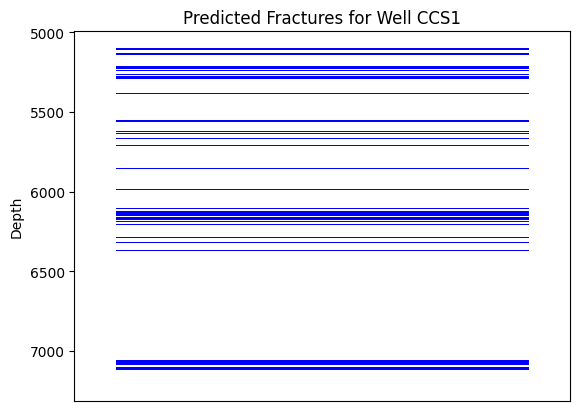

Number of features considered: 44

Training on ['CCS1', 'VW2'], testing on VW1

Results for training:
Average accuracy is 88.64%
Average precision is 82.86%
Average recall is 83.37%
Average f1 is 83.04%

Results for testing:
Predicted 1768 fractures when there are actually 309
Average accuracy is 51.78%
Average precision is 5.49%
Average recall is 31.39%
Average f1 is 9.34%


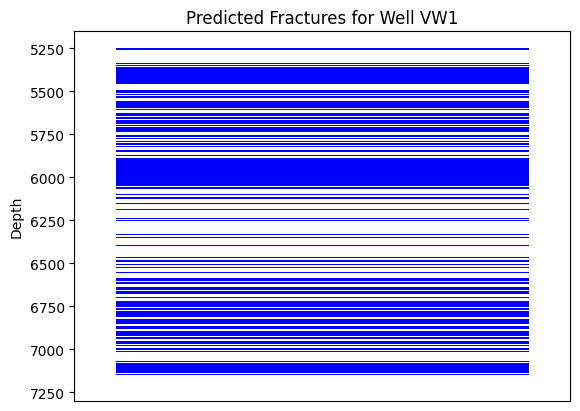

Number of features considered: 44

Training on ['CCS1', 'VW1'], testing on VW2

Results for training:
Average accuracy is 90.86%
Average precision is 86.42%
Average recall is 86.24%
Average f1 is 86.27%

Results for testing:
Predicted 879 fractures when there are actually 394
Average accuracy is 73.63%
Average precision is 17.52%
Average recall is 39.09%
Average f1 is 24.19%


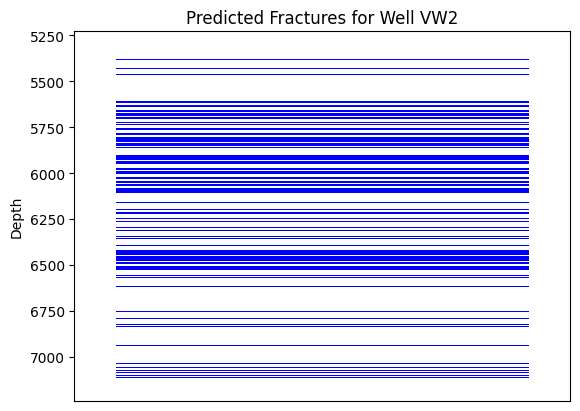

In [ ]:
for i in range(len(WELLS)):
  ### iterate through which well is used for testing (rest used for training)
  curr_well = WELLS[i]
  print(f"\nTraining on {[well for well in WELLS if well != curr_well]},\
          testing on {curr_well}")
  testset = datasets[curr_well]
  trainsets = [datasets[well] for well in WELLS if well != curr_well]
  trainset = pd.concat(trainsets)
  depths = testset["DEPT"]

  ### optional undersampling of majority class
  #trainset = balance_dataset(trainset)

  X_train = np.array(trainset.drop(columns=["HAS_FRAC", "DEPT", "FORM"]))
  y_train = np.array(trainset["HAS_FRAC"])
  X_test = np.array(testset.drop(columns=["HAS_FRAC", "DEPT", "FORM"]))
  y_test = np.array(testset["HAS_FRAC"])

  ### optional data preprocessing steps
  X_train, X_test = normalize(X_train, X_test)
  #X_train, X_test = apply_PCA(X_train, X_test)

  ### train/test model and plot results
  train_model(X_train, y_train)
  y_pred = test_model(X_test, y_test)
  plot_depths_with_labels(curr_well, depths, y_pred, y_test)